In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("SeoulBikeData (1).csv",encoding='CP949')

In [2]:
data

,Date,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


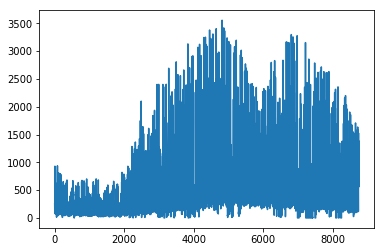

In [3]:
plt.plot(data['Rented Bike Count'])

In [4]:
cols=data.columns[1:-3]
cols=cols.drop(['Visibility (10m)','Hour'])

In [5]:
len(cols)

8

In [6]:
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,8)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

7008 876 876


In [8]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -4])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [9]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)


6984
852
852


In [10]:
print(trainX.shape)
print(trainY.shape)

(6984, 24, 8)
(6984,)


(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f52a99fa278>)

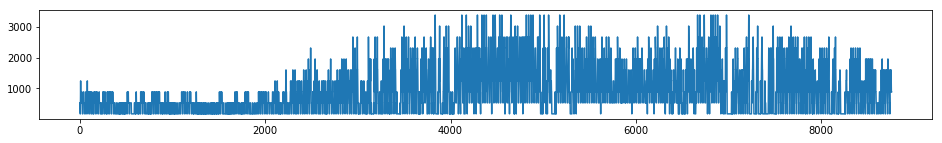

In [122]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

my_augmenter = (Quantize(n_levels=[10]))
X_aug1= my_augmenter.augment(data['Rented Bike Count'].values)
plot(X_aug1)

(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe26a078ac8>)

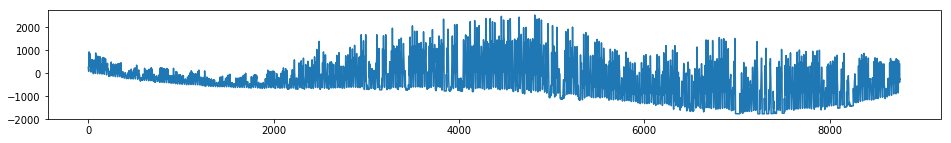

In [89]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

my_augmenter = (Drift())
X_aug2= my_augmenter.augment(data['Rented Bike Count'].values)
plot(X_aug2)

In [92]:
from tsaug import RandomTimeWarp, RandomMagnify, RandomJitter, RandomTrend

ImportError: cannot import name 'RandomTimeWarp'

In [123]:
quant=scaler.fit_transform(X_aug1.reshape(-1,1))

In [124]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train_q,val_q, test_q = quant[0:train_size,:],quant[train_size:train_size+val_size,:], quant[train_size+val_size:,:]
print(len(train_q),len(val_q), len(test_q))

7008 876 876


In [125]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [126]:
look_back = 24
trainX_q, trainY_q = create_dataset(train_q, look_back)
valX_q, valY_q = create_dataset(val_q, look_back)
testX_q, testY_q = create_dataset(test_q, look_back)

6984
852
852


In [127]:
look_back = 24
trainX_o, trainY_o = create_dataset(train, look_back)
valX_o, valY_o = create_dataset(val, look_back)
testX_o, testY_o = create_dataset(test, look_back)

6984
852
852


In [128]:
trainX_q = np.reshape(trainX_q, (trainX_q.shape[0], trainX_q.shape[1], 1))
valX_q = np.reshape(valX_q, (valX_q.shape[0], valX_q.shape[1],1))
testX_q = np.reshape(testX_q, (testX.shape[0],testX_q.shape[1], 1 ))

In [129]:
trainX_o = np.reshape(trainX_o, (trainX_o.shape[0], trainX_o.shape[1], 1))
valX_o = np.reshape(valX_o, (valX_o.shape[0], valX_o.shape[1],1))
testX_o = np.reshape(testX_o, (testX_o.shape[0],testX_o.shape[1], 1 ))

In [130]:
print(trainX.shape)
print(trainX_q.shape)

(6984, 24, 8)
(6984, 24, 1)


In [131]:
print(valX.shape)
print(valX_q.shape)

(852, 24, 8)
(852, 24, 1)


In [215]:
first_input = Input(shape=(24,1))
in1=layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(6, 1))(first_input)
in2=layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(6, 1))(in1)
#in3=layers.Conv1D(filters=128, kernel_size=1, activation='relu')(in2)
in4=layers.MaxPooling1D(pool_size=2)(in2)
in5=layers.Flatten()(in4)
in6=layers.Dense(100)(in5)
in6=layers.Dense(1)(in6)
#in6=layers.Bidirectional(LSTM(50))(first_input)

inputs = Input(shape=(24, 8), name='inputs')
#lstm_out = Bidirectional(LSTM(80, return_sequences=False))(inputs)
lstm_out = LSTM(50, return_sequences=False)(inputs)


#lstm_out = LSTM(64, return_sequences=True)(lstm_out)

    # Attention layer
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([lstm_out, lstm_out])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([lstm_out, attn_out])
#flat_out = Flatten()(concat_out)

    # Dense layer
#dense_out = Dense(6, activation='relu')(flat_out)
concat=layers.Concatenate()([in6, lstm_out])
#dens=layers.Dense(100,activation='relu')(concat)
#dens=layers.Dense(100)
#dens= SeqSelfAttention(attention_activation='relu')(concat)

dens=layers.Dense(1)(concat)

model=tf.keras.Model(inputs=[first_input,inputs],outputs=[dens])
model.compile(optimizer='adam', loss='mse')


In [199]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 20, 64)       384         input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 20, 64)       4160        conv1d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 10, 64)       0           conv1d_37[0][0]                  
___________________________________________________________________________________________

In [200]:
checkpoint_path = "saved_weights/multi_bike_onestep_aug50_10.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [201]:
hist = model.fit([trainX_q,trainX],trainY, epochs = 150,validation_data=([valX_q,valX],valY), verbose = 1,callbacks=[cb])

Train on 6984 samples, validate on 852 samples
Epoch 1/150
6912/6984 [============================>.] - ETA: 0s - loss: 0.0062
Epoch 00001: val_loss improved from inf to 0.00123, saving model to saved_weights/multi_bike_onestep_aug50_10.hdf5
6984/6984 [==============================] - 3s 413us/sample - loss: 0.0062 - val_loss: 0.0012
Epoch 2/150
6944/6984 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00002: val_loss improved from 0.00123 to 0.00079, saving model to saved_weights/multi_bike_onestep_aug50_10.hdf5
6984/6984 [==============================] - 2s 222us/sample - loss: 0.0013 - val_loss: 7.9497e-04
Epoch 3/150
6944/6984 [============================>.] - ETA: 0s - loss: 9.3787e-04
Epoch 00003: val_loss improved from 0.00079 to 0.00067, saving model to saved_weights/multi_bike_onestep_aug50_10.hdf5
6984/6984 [==============================] - 2s 222us/sample - loss: 9.3528e-04 - val_loss: 6.7046e-04
Epoch 4/150
6944/6984 [============================>.] - ET

6944/6984 [============================>.] - ETA: 0s - loss: 3.8089e-04
Epoch 00032: val_loss did not improve from 0.00036
6984/6984 [==============================] - 2s 220us/sample - loss: 3.8018e-04 - val_loss: 3.7820e-04
Epoch 33/150
6944/6984 [============================>.] - ETA: 0s - loss: 3.7943e-04
Epoch 00033: val_loss did not improve from 0.00036
6984/6984 [==============================] - 2s 218us/sample - loss: 3.7931e-04 - val_loss: 3.7417e-04
Epoch 34/150
6944/6984 [============================>.] - ETA: 0s - loss: 3.8037e-04
Epoch 00034: val_loss did not improve from 0.00036
6984/6984 [==============================] - 2s 218us/sample - loss: 3.8009e-04 - val_loss: 4.0247e-04
Epoch 35/150
6848/6984 [============================>.] - ETA: 0s - loss: 3.7317e-04
Epoch 00035: val_loss did not improve from 0.00036
6984/6984 [==============================] - 2s 229us/sample - loss: 3.7385e-04 - val_loss: 4.7700e-04
Epoch 36/150
6944/6984 [============================>.] -

Epoch 66/150
6944/6984 [============================>.] - ETA: 0s - loss: 3.3680e-04
Epoch 00066: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 260us/sample - loss: 3.3707e-04 - val_loss: 3.6039e-04
Epoch 67/150
6976/6984 [============================>.] - ETA: 0s - loss: 3.3538e-04
Epoch 00067: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 260us/sample - loss: 3.3561e-04 - val_loss: 3.9155e-04
Epoch 68/150
6976/6984 [============================>.] - ETA: 0s - loss: 3.4619e-04
Epoch 00068: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 261us/sample - loss: 3.5185e-04 - val_loss: 8.1402e-04
Epoch 69/150
6784/6984 [============================>.] - ETA: 0s - loss: 3.5439e-04
Epoch 00069: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 247us/sample - loss: 3.5072e-04 - val_loss: 3.5995e-04
Epoch 70/150
6976/6984 [====================

6880/6984 [============================>.] - ETA: 0s - loss: 3.1336e-04
Epoch 00100: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 254us/sample - loss: 3.1518e-04 - val_loss: 3.9061e-04
Epoch 101/150
6976/6984 [============================>.] - ETA: 0s - loss: 3.1833e-04
Epoch 00101: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 261us/sample - loss: 3.1836e-04 - val_loss: 3.7093e-04
Epoch 102/150
6976/6984 [============================>.] - ETA: 0s - loss: 3.1103e-04
Epoch 00102: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 261us/sample - loss: 3.1131e-04 - val_loss: 3.9691e-04
Epoch 103/150
6976/6984 [============================>.] - ETA: 0s - loss: 3.1721e-04
Epoch 00103: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 260us/sample - loss: 3.1719e-04 - val_loss: 4.1539e-04
Epoch 104/150
6976/6984 [============================>

6976/6984 [============================>.] - ETA: 0s - loss: 3.0766e-04
Epoch 00134: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 260us/sample - loss: 3.0769e-04 - val_loss: 3.8889e-04
Epoch 135/150
6976/6984 [============================>.] - ETA: 0s - loss: 3.0106e-04
Epoch 00135: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 260us/sample - loss: 3.0096e-04 - val_loss: 3.8622e-04
Epoch 136/150
6976/6984 [============================>.] - ETA: 0s - loss: 2.9518e-04
Epoch 00136: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 262us/sample - loss: 2.9504e-04 - val_loss: 3.9729e-04
Epoch 137/150
6848/6984 [============================>.] - ETA: 0s - loss: 2.9555e-04
Epoch 00137: val_loss did not improve from 0.00035
6984/6984 [==============================] - 2s 285us/sample - loss: 2.9620e-04 - val_loss: 3.9715e-04
Epoch 138/150
6944/6984 [============================>

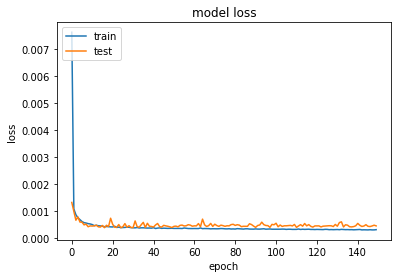

In [164]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

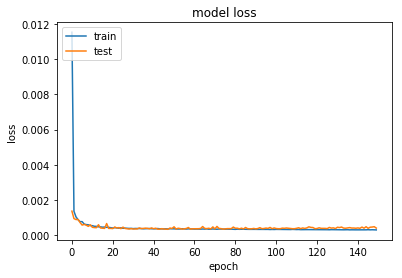

In [119]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

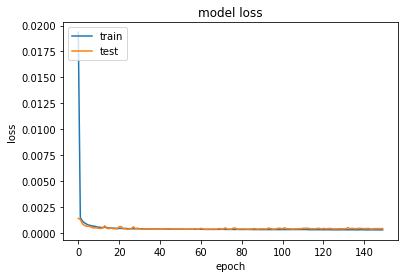

In [143]:

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [216]:
model.load_weights("saved_weights/multi_bike_onestep_aug50_10.hdf5")

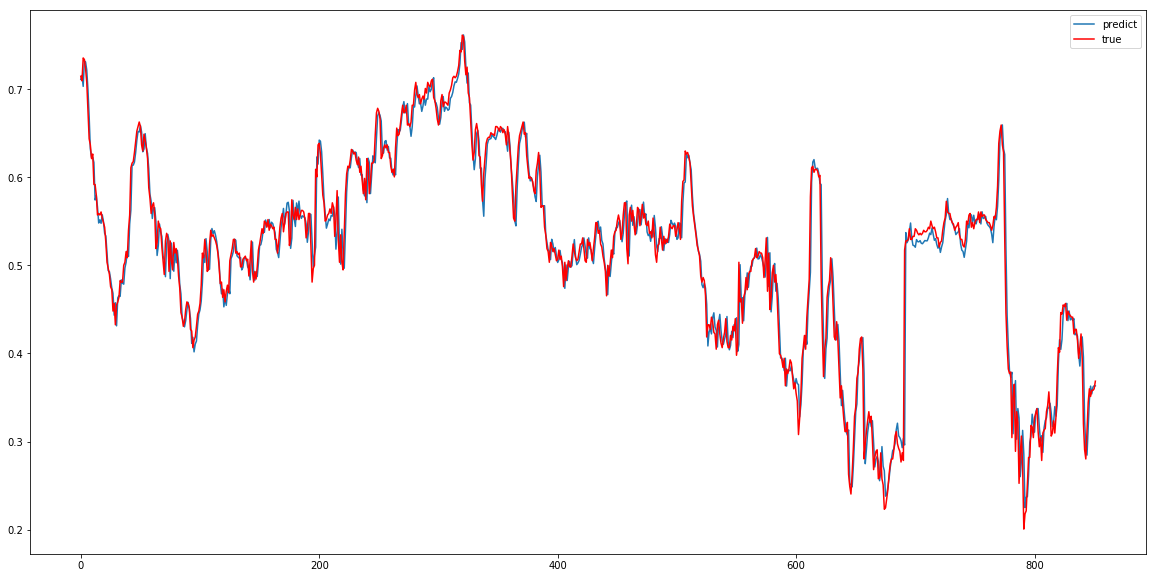

Test RMSE: 0.02080
Test MAE: 0.01374
Test MSE: 0.00043
Test RMSE: 74.60037
Test MAE: 49.29683


In [217]:


from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

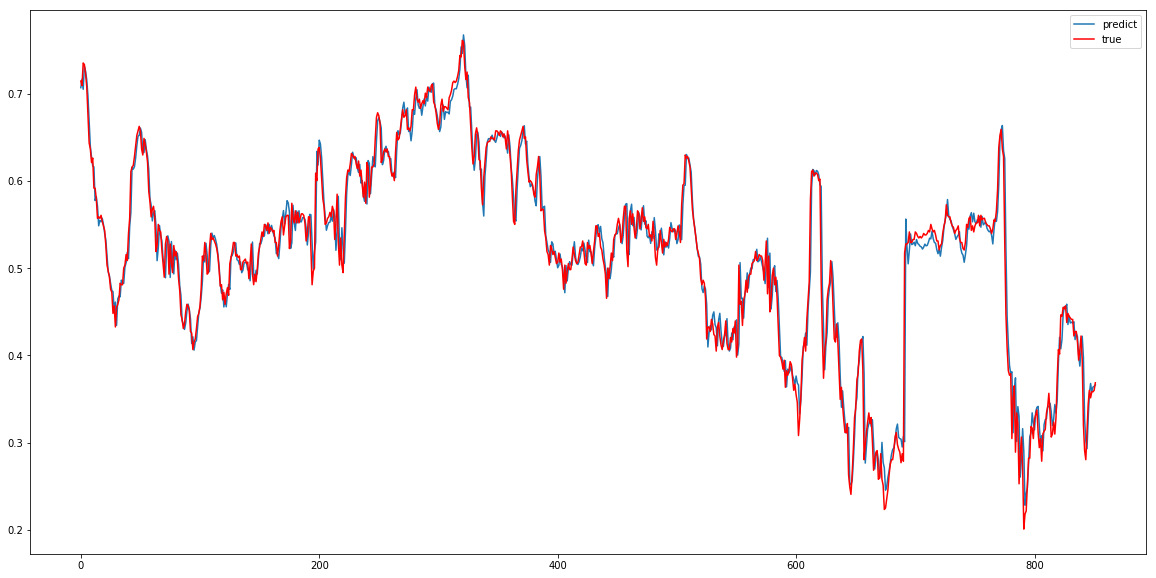

Test RMSE: 0.02086
Test MAE: 0.01381
Test MSE: 0.00044
Test RMSE: 74.82544
Test MAE: 49.53196


In [177]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

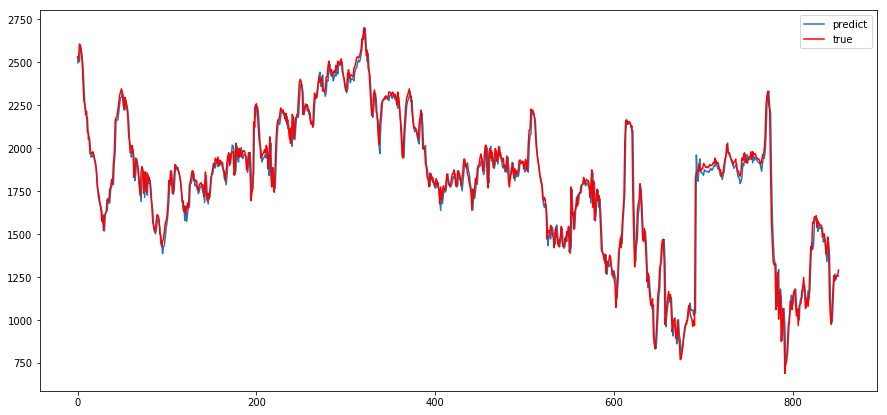

In [105]:
plt.figure(figsize=(15,7))
#plt.legend([yhat_inverse, testY_inverse], ['predict','true'])

#plt.legend(prop={'size':12})
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
pyplot.show()

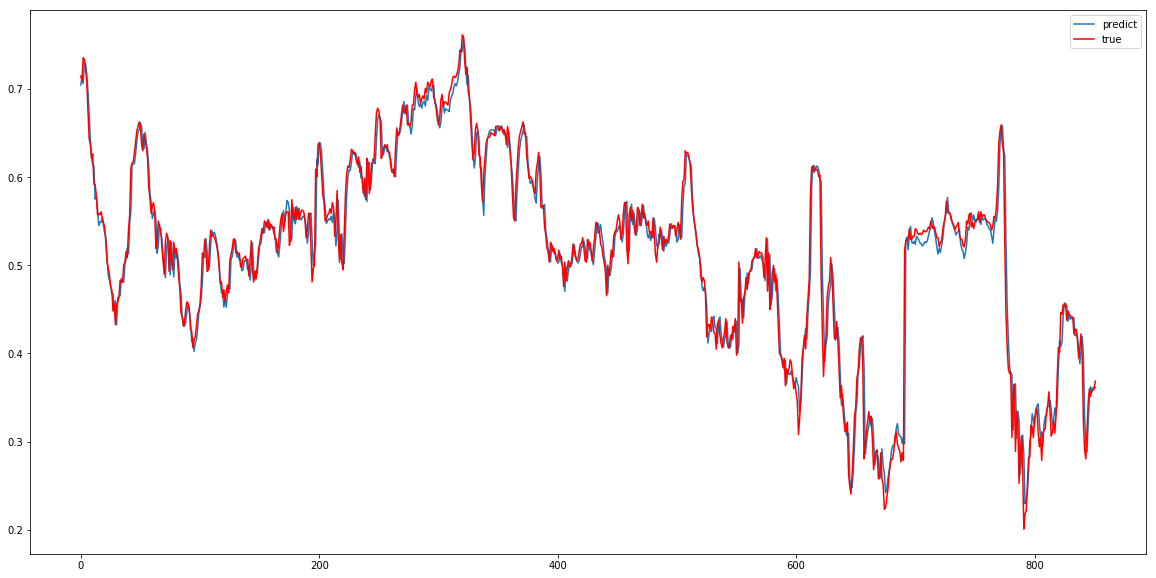

Test RMSE: 0.02090
Test MAE: 0.01385
Test MSE: 0.00044
Test RMSE: 74.95754
Test MAE: 49.66027


In [51]:
##saved_weights/multi_bike_Aug_onestep
##quant30

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)